In [30]:
import os
import utils
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as Data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from torch.autograd import Variable
from torch import autograd

import warnings
warnings.filterwarnings("ignore")

batch_size = 256
lr = 0.003
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

X = pd.read_csv('data/X_metabric_cleaned.csv')
y = pd.read_csv('data/y_LS_metabric_cleaned.csv')

X1, X_test1, Y1, Y_test1 = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

X = np.array(X1)
Y = np.array(Y1)
X_test = np.array(X_test1)
Y_test = np.array(Y_test1)

X=torch.from_numpy(X).float() 
Y=torch.from_numpy(Y).float()
X_test=torch.from_numpy(X_test).float()
Y_test=torch.from_numpy(Y_test).float()

In [31]:
class Generator(nn.Module):
    def __init__ (self,ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(50, 64, bias = True),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
        
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self,input):
        return self.main(input)
    
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):netG = nn.DataParallel(netG, list(range(ngpu)))
print(netG)

class Discriminator(nn.Module):
    def __init__ (self,ngpu):
        self.ngpu = ngpu
        super(Discriminator, self).__init__()

        self.l1=nn.Linear(in_features = 31,out_features = 64,bias = True)
        self.i1=nn.InstanceNorm1d(64)
        self.r1=nn.LeakyReLU(0.2, inplace=True)
        
        self.l2=nn.Linear(in_features = 64,out_features = 128,bias = True)
        self.i2=nn.InstanceNorm1d(128)
        self.r2=nn.LeakyReLU(0.2, inplace=True)
            
        self.l3=nn.Linear(in_features = 128,out_features = 64,bias = True)
        self.i3=nn.InstanceNorm1d(64)
        self.r3=nn.LeakyReLU(0.2, inplace=True)
           
        self.l4=nn.Linear(64,1)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self,input):
        out=self.l1(input)
        out=out.reshape(256,1,64)
        out=self.i1(out)
        out=out.reshape(256,64)
        out=self.r1(out)
        
        out=self.l2(out)
        out=out.reshape(256,1,128)
        out=self.i2(out)
        out=out.reshape(256,128)
        out=self.r2(out)

        out=self.l3(out)
        out=out.reshape(256,1,64)
        out=self.i3(out)
        out=out.reshape(256,64)
        out=self.r3(out)
        
        out=self.l4(out)
        
        return out
    
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):netD = nn.DataParallel(netD, list(range(ngpu)))
print(netD)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Discriminator(
  (l1): Linear(in_features=31, out_features=64, bias=True)
  (i1): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (r1): LeakyReLU(negative_slope=0.2, inplace=True)
  (l2): Linear(in_features=64, out_features=128, bias=True)
  (i2): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, tr

Starting Training Loop...
[0]	Loss_D: 9.3491	Loss_G: 0.9432
[50]	Loss_D: 0.6808	Loss_G: 0.6558
[100]	Loss_D: 0.7189	Loss_G: 0.1436
[150]	Loss_D: -0.0069	Loss_G: 0.4860
[200]	Loss_D: 0.2472	Loss_G: 0.3840
[250]	Loss_D: 0.4410	Loss_G: 0.2904
[300]	Loss_D: 0.0713	Loss_G: 0.5484
[350]	Loss_D: -0.0307	Loss_G: 0.2710
[400]	Loss_D: -0.0817	Loss_G: 0.2022
[450]	Loss_D: 0.0958	Loss_G: 0.3171
[500]	Loss_D: 0.2195	Loss_G: 0.3229
[550]	Loss_D: 0.0997	Loss_G: 0.1936
[600]	Loss_D: 0.2235	Loss_G: 0.1487
[650]	Loss_D: 0.4052	Loss_G: 0.3594
[700]	Loss_D: -0.0304	Loss_G: 0.2543
[750]	Loss_D: 0.1843	Loss_G: 0.3060
[800]	Loss_D: -0.0124	Loss_G: 0.2250
[850]	Loss_D: 0.2760	Loss_G: 0.5171
[900]	Loss_D: -0.1978	Loss_G: 0.1721
[950]	Loss_D: -0.0209	Loss_G: 0.2109
[1000]	Loss_D: 0.1563	Loss_G: 0.3439
[1050]	Loss_D: 0.0528	Loss_G: 0.2885
[1100]	Loss_D: 0.0193	Loss_G: 0.2913
[1150]	Loss_D: 0.5025	Loss_G: 0.3701
[1200]	Loss_D: 0.3317	Loss_G: 0.3924
[1250]	Loss_D: 0.1223	Loss_G: 0.3160
[1300]	Loss_D: -0.0244	Loss_

[10950]	Loss_D: -0.0794	Loss_G: 0.2369
[11000]	Loss_D: -0.0140	Loss_G: 0.2414
[11050]	Loss_D: 0.0343	Loss_G: 0.2799
[11100]	Loss_D: -0.0168	Loss_G: 0.2251
[11150]	Loss_D: 0.0161	Loss_G: 0.2873
[11200]	Loss_D: 0.0791	Loss_G: 0.2956
[11250]	Loss_D: -0.0934	Loss_G: 0.2217
[11300]	Loss_D: -0.0952	Loss_G: 0.2281
[11350]	Loss_D: 0.0801	Loss_G: 0.3070
[11400]	Loss_D: -0.0148	Loss_G: 0.2718
[11450]	Loss_D: 0.0871	Loss_G: 0.3136
[11500]	Loss_D: 0.0472	Loss_G: 0.2938
[11550]	Loss_D: 0.0743	Loss_G: 0.3115
[11600]	Loss_D: -0.0377	Loss_G: 0.2250
[11650]	Loss_D: -0.0263	Loss_G: 0.2683
[11700]	Loss_D: -0.0932	Loss_G: 0.2309
[11750]	Loss_D: 0.0503	Loss_G: 0.2787
[11800]	Loss_D: 0.0912	Loss_G: 0.3225
[11850]	Loss_D: -0.0677	Loss_G: 0.2346
[11900]	Loss_D: 0.1015	Loss_G: 0.3408
[11950]	Loss_D: -0.0214	Loss_G: 0.2617


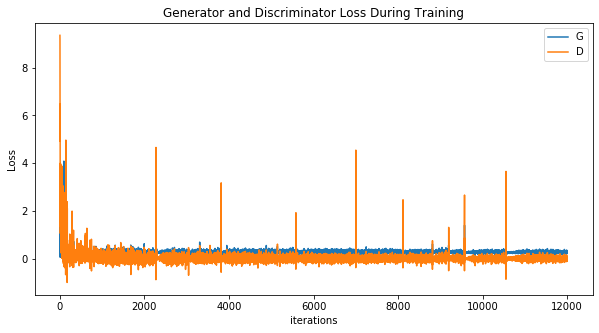

In [32]:
netG.weight_init(mean=0, std=0.02)
netD.weight_init(mean=0, std=0.02)

criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr,betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr,betas=(0.5, 0.999))

def calculate_gradient_penalty(real_images, fake_images):
    eta = torch.FloatTensor(batch_size,1).uniform_(0,1)
    eta = eta.expand(batch_size, real_images.size(1))
    if device:
        eta = eta.to(device)
    else:
        eta = eta

    interpolated = eta * real_images + ((1 - eta) * fake_images)

    if device:
        interpolated = interpolated.to(device)
    else:
        interpolated = interpolated

    # define it to calculate gradient
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                            grad_outputs=torch.ones(
                                prob_interpolated.size()).to(device) if device else torch.ones(
                                prob_interpolated.size()),
                            create_graph=True, retain_graph=True)[0]

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return grad_penalty

torch.manual_seed(1368)
rs = np.random.RandomState(1368)

G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(12000):
    for _ in range(5):
        netD.zero_grad()
            
        idx = rs.choice(X.shape[0],batch_size)
        x_data=X[idx]
        y_data=Y[idx]
        
        c = torch.cat((x_data,y_data),dim=1).to(device)
        d_real = netD(c)
        
        d_real_loss = criterion(d_real,torch.full_like(d_real, 1))
        d_real_loss.backward()
        
        noise = torch.randn(len(x_data), 20)

        y = x_data.to(device)
        y = torch.cat((noise,x_data),dim=1).to(device)

        fake = netG(y).detach()
        x_data=x_data.to(device)
        
        z = torch.cat((x_data,fake),dim=1).to(device)
        
        d_fake = netD(z)
        d_fake_loss = criterion(d_fake,torch.full_like(d_fake, 0))
        d_fake_loss.backward()

        gradient_penalty = calculate_gradient_penalty(c.data, fake.data)
        gradient_penalty.backward()

        d_loss = d_fake_loss - d_real_loss + gradient_penalty
        Wasserstein_D = d_real_loss - d_fake_loss
        
        optimizerD.step()
        
    idx = rs.choice(X.shape[0],batch_size)
    x_data=X[idx]
    y_data=Y[idx]
            
    netG.zero_grad()

    noise = torch.randn(len(x_data), 20)
    a = x_data.to(device)
    a = torch.cat((noise,x_data),dim=1).to(device)
    fake = netG(a)
    x_data=x_data.to(device)

    b = torch.cat((x_data,fake),dim=1).to(device)
    
    d_g = netD(b)
        
    g_loss = criterion(d_g, torch.full_like(d_g, 1))
        
    g_loss.backward()
    optimizerG.step()
        
    if epoch % 50 == 0:
        print('[%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                % (epoch,d_loss.item(), g_loss.item()))

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    
torch.save(netG, 'data\G_parameter.pkl')
torch.save(netD, 'data\D_parameter.pkl')

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
# netG = Generator(ngpu).to(device)
# save_path = 'data\G_parameter.pkl'
# netG=torch.load(save_path)

d=torch.squeeze(X_test, dim=1)

noise = torch.randn(502, 20)
a = torch.cat((noise,d),dim=1).to(device)
fake = netG(a).detach().cpu()
fake = fake.numpy()

fake1 = fake
fake=torch.from_numpy(fake)
fake1=np.rint(fake1)

from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
y_true = Y_test
y_scores = fake.view(-1)

print("auc: {}".format(roc_auc_score(y_true, y_scores)))
print("acc: {}".format(accuracy_score(y_true,fake1)))
# print(classification_report(y_true,fake1))

auc: 0.9213690145318827
acc: 0.9043824701195219
